
# Volatility Forecasting with GARCH + ML (yfinance, pandas, scikit-learn, arch, matplotlib)

This notebook implements **volatility forecasting** using both traditional GARCH models and **ML-enhanced** approaches to predict next-day volatility.  
It uses **trusted libraries** widely adopted in quantitative finance and data science:

- **yfinance** for data sourcing (Yahoo Finance historical prices)  
- **pandas** / **numpy** for data manipulation and vectorized calculations  
- **arch** for GARCH modeling (volatility clustering)  
- **scikit-learn** for Random Forest regression and time-series cross-validation  
- **matplotlib** for plotting  
- (Optional) **warnings**, **dataclasses** for clean utilities

**What you get**
1. Baseline GARCH(1,1) volatility forecasting model.
2. ML model (Random Forest) trained on lagged volatility, volume, and return features.
3. Risk-adjusted position sizing strategy using predicted volatility.
4. Performance comparison with volatility-based risk management.
5. Risk metrics: CAGR, Sharpe (annualized), Max Drawdown, Volatility-adjusted returns.
6. Clean plots and CSV export of forecasts and equity curves.

> Tip: Run the installation cell first if your environment is missing any packages.


In [10]:

# If running locally or in a fresh environment, uncomment and run:
# %pip install --quiet yfinance pandas numpy scikit-learn arch matplotlib


In [1]:

import warnings, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from dataclasses import dataclass

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# GARCH modeling
try:
    from arch import arch_model
    from arch.univariate import GARCH, ConstantMean
except Exception:
    arch_model = None

plt.rcParams["figure.figsize"] = (10, 5)  # single chart per cell per instructions


In [2]:

# ------------------------------- Parameters -------------------------------- #
TICKER = "SPY"           # change to your preferred ticker (ETF/stock)
START = "2010-01-01"
LOOKBACK_DAYS = 252      # rolling window for realized volatility calculation

SLIPPAGE_BPS = 1.0       # slippage per trade event in basis points
RISK_FREE = 0.015        # 1.5% annualized risk-free for Sharpe
VOL_TARGET = 0.15        # 15% annualized volatility target for position sizing
MAX_LEVERAGE = 2.0       # maximum leverage allowed
REBALANCE_FREQ = 5       # rebalance every N days
# --------------------------------------------------------------------------- #


In [3]:

def cagr(equity, periods_per_year=252):
    if len(equity) < 2:
        return np.nan
    total_ret = equity.iloc[-1] / equity.iloc[0] - 1
    years = len(equity) / periods_per_year
    return (1 + total_ret) ** (1/years) - 1 if years > 0 else np.nan

def sharpe(returns, rf=RISK_FREE, periods_per_year=252):
    if returns.std() == 0 or returns.isna().all():
        return np.nan
    mean_excess = returns.mean() * periods_per_year - rf
    vol = returns.std() * np.sqrt(periods_per_year)
    return mean_excess / (vol + 1e-12)

def max_drawdown(equity):
    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    return dd.min()

@dataclass
class Metrics:
    cagr: float
    sharpe: float
    max_dd: float
    total_return: float
    realized_vol: float

def compute_metrics(strat_df):
    equity = strat_df["equity"].dropna()
    rets = strat_df["strat_ret"].dropna()
    return Metrics(
        cagr=cagr(equity),
        sharpe=sharpe(rets),
        max_dd=max_drawdown(equity),
        total_return=(equity.iloc[-1] - 1.0) if len(equity) else np.nan,
        realized_vol=rets.std() * np.sqrt(252) if len(rets) > 1 else np.nan
    )

def fetch_prices(ticker=TICKER, start=START):
    df = yf.download(ticker, start=start, auto_adjust=True, progress=False)
    df = df[["Open","High","Low","Close","Volume"]].dropna()
    
    # Flatten MultiIndex columns if they exist
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]
    
    return df

def add_volatility_features(df, lookback=LOOKBACK_DAYS):
    df = df.copy()
    df["ret"] = df["Close"].pct_change()
    
    # Realized volatility measures
    df["rv_1d"] = df["ret"].abs()  # absolute returns
    df["rv_5d"] = df["ret"].rolling(5).std() * np.sqrt(252)
    df["rv_20d"] = df["ret"].rolling(20).std() * np.sqrt(252)
    df["rv_60d"] = df["ret"].rolling(60).std() * np.sqrt(252)
    
    # Intraday volatility proxies
    df["high_low"] = (df["High"] / df["Low"] - 1) * 100
    df["open_close"] = (df["Close"] / df["Open"] - 1) * 100
    
    # Volume features
    df["volume_ma"] = df["Volume"].rolling(20).mean()
    df["volume_ratio"] = df["Volume"] / (df["volume_ma"] + 1e-9)
    df["volume_vol"] = np.log(df["Volume"]).rolling(20).std()
    
    # Return features
    df["ret_lag1"] = df["ret"].shift(1)
    df["ret_lag2"] = df["ret"].shift(2)
    df["ret_lag5"] = df["ret"].shift(5)
    df["ret_abs_ma"] = df["rv_1d"].rolling(10).mean()
    
    # Momentum and trend
    df["mom_5"] = df["Close"].pct_change(5)
    df["mom_20"] = df["Close"].pct_change(20)
    df["trend_20"] = df["Close"] / df["Close"].rolling(20).mean() - 1
    
    return df

def fit_garch_model(returns, verbose=True):
    """Fit GARCH(1,1) model to return series"""
    if arch_model is None:
        if verbose:
            print("[GARCH] arch package not available, skipping GARCH modeling")
        return None, None
    
    try:
        # Remove any infinite or NaN values
        clean_returns = returns.dropna().replace([np.inf, -np.inf], np.nan).dropna()
        clean_returns = clean_returns * 100  # Convert to percentage
        
        if len(clean_returns) < 100:
            if verbose:
                print("[GARCH] Insufficient data for GARCH modeling")
            return None, None
        
        # Fit GARCH(1,1) model
        model = arch_model(clean_returns, vol='GARCH', p=1, q=1, rescale=False)
        fitted = model.fit(disp='off')
        
        if verbose:
            print(f"[GARCH] Model fitted successfully")
            print(f"[GARCH] Log-likelihood: {fitted.loglikelihood:.2f}")
        
        return model, fitted
    except Exception as e:
        if verbose:
            print(f"[GARCH] Error fitting model: {str(e)}")
        return None, None

def forecast_garch_volatility(fitted_model, steps=1):
    """Generate GARCH volatility forecasts"""
    if fitted_model is None:
        return np.nan
    try:
        forecast = fitted_model.forecast(horizon=steps, reindex=False)
        vol_forecast = np.sqrt(forecast.variance.iloc[-1, 0]) / 100  # Convert back to decimal
        return vol_forecast
    except Exception:
        return np.nan

def make_ml_features(df):
    feature_cols = [
        "rv_5d", "rv_20d", "rv_60d", "high_low", "open_close",
        "volume_ratio", "volume_vol", "ret_lag1", "ret_lag2", "ret_lag5",
        "ret_abs_ma", "mom_5", "mom_20", "trend_20"
    ]
    X = df[feature_cols].copy()
    return X.fillna(method="ffill").fillna(method="bfill"), feature_cols

def train_volatility_ml(df, target_col="rv_1d", verbose=True):
    """Train ML model to predict next-day realized volatility"""
    X, feature_cols = make_ml_features(df)
    y = df[target_col].shift(-1)  # Predict next day volatility
    
    # Remove rows with missing target
    valid_idx = y.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]
    
    if len(X) < 100:
        if verbose:
            print("[ML] Insufficient data for ML training")
        return None, np.nan
    
    # Time series split for validation
    tscv = TimeSeriesSplit(n_splits=5)
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10))
    ])
    
    scores = []
    for train_idx, test_idx in tscv.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred = model.predict(X.iloc[test_idx])
        scores.append(r2_score(y.iloc[test_idx], y_pred))
    
    if verbose:
        print(f"[ML] TimeSeries CV R² (mean±std): {np.mean(scores):.3f} ± {np.std(scores):.3f}")
    
    # Fit final model
    model.fit(X, y)
    
    # Generate predictions for all valid dates
    predictions = pd.Series(index=df.index, dtype=float)
    predictions.loc[X.index] = model.predict(X)
    
    return model, predictions

def calculate_position_size(predicted_vol, target_vol=VOL_TARGET, max_leverage=MAX_LEVERAGE):
    """Calculate position size based on predicted volatility"""
    if pd.isna(predicted_vol) or predicted_vol <= 0:
        return 1.0
    
    # Inverse volatility scaling
    position_size = target_vol / predicted_vol
    
    # Apply leverage constraints
    position_size = np.clip(position_size, 1/max_leverage, max_leverage)
    
    return position_size

def apply_slippage(returns, trade_flags, slippage_bps=SLIPPAGE_BPS):
    cost_per_trade = slippage_bps / 1e4
    cost_series = trade_flags.astype(float) * cost_per_trade
    return returns - cost_series

def backtest_vol_strategy(df, vol_predictions, rebal_freq=REBALANCE_FREQ):
    """Backtest strategy with volatility-based position sizing"""
    df = df.copy()
    
    # Calculate position sizes
    df["position_size"] = vol_predictions.apply(calculate_position_size)
    
    # Rebalance only every N days
    df["rebalance"] = False
    df.iloc[::rebal_freq, df.columns.get_loc("rebalance")] = True
    df["rebalance"].iloc[0] = True  # First day
    
    # Forward fill position sizes between rebalance dates
    df["active_position"] = np.nan
    df.loc[df["rebalance"], "active_position"] = df.loc[df["rebalance"], "position_size"]
    df["active_position"] = df["active_position"].fillna(method="ffill")
    
    # Calculate strategy returns
    df["strat_ret"] = df["active_position"].shift(1) * df["ret"]
    
    # Apply transaction costs on rebalance days
    trade_flags = df["rebalance"].shift(1).fillna(False)
    df["strat_ret"] = apply_slippage(df["strat_ret"], trade_flags)
    
    # Calculate equity curve
    df["equity"] = (1 + df["strat_ret"]).cumprod()
    
    return df


## 1) Fetch & Prepare Data

In [4]:
px = fetch_prices(TICKER, START)
df = add_volatility_features(px, LOOKBACK_DAYS)
df = df.dropna(subset=["rv_20d", "volume_ratio"])
print(f"Data shape: {df.shape}")
df.tail()

Data shape: (3907, 22)


,Open,High,Low,Close,Volume,ret,rv_1d,rv_5d,rv_20d,rv_60d,...,volume_ma,volume_ratio,volume_vol,ret_lag1,ret_lag2,ret_lag5,ret_abs_ma,mom_5,mom_20,trend_20
Date,,,,,,,,,,,,,,,,,,,,,
2025-08-07,636.239990,636.979980,629.109985,632.250000,74205800,-0.000838,0.000838,0.191926,0.101658,0.106457,...,72734970.0,1.020222,0.227659,0.007660,-0.005070,-0.003751,0.005728,0.000269,0.010275,0.003699
2025-08-08,634.059998,637.650024,633.739990,637.179993,64051600,0.007798,0.007798,0.126600,0.103599,0.106732,...,72754040.0,0.880385,0.227518,-0.000838,0.007660,-0.016390,0.006085,0.024867,0.021744,0.010438
2025-08-11,637.460022,638.950012,634.659973,635.919983,58742300,-0.001977,0.001977,0.093350,0.104112,0.106962,...,73096230.0,0.803630,0.220193,0.007798,-0.000838,0.015200,0.006258,0.007526,0.017781,0.007552
2025-08-12,638.289978,642.849976,636.789978,642.690002,64730800,0.010646,0.010646,0.090134,0.107683,0.108408,...,72616905.0,0.891401,0.220953,-0.001977,0.007798,-0.005070,0.007059,0.023441,0.033031,0.016623
2025-08-13,644.909973,646.190002,642.679993,644.890015,60044700,0.003423,0.003423,0.086176,0.107700,0.108016,...,71169765.0,0.843683,0.216913,0.010646,-0.001977,0.007660,0.007275,0.019138,0.033113,0.018438


## 2) GARCH Volatility Modeling

[GARCH] Model fitted successfully
[GARCH] Log-likelihood: -5024.45

[GARCH] Generating rolling forecasts...
[GARCH] Generated 3657 forecasts
[GARCH] Generated 3657 forecasts


[GARCH] Model fitted successfully
[GARCH] Log-likelihood: -5024.45

[GARCH] Generating rolling forecasts...
[GARCH] Generated 3657 forecasts
[GARCH] Generated 3657 forecasts


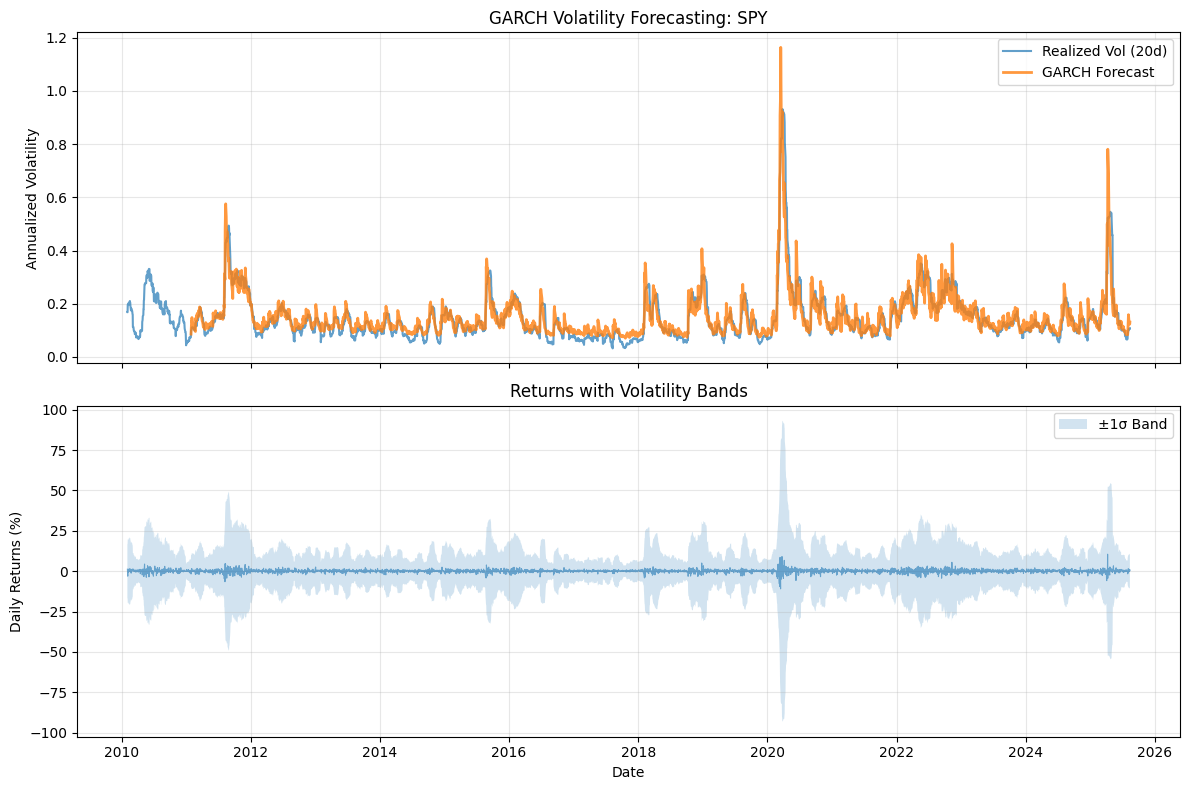

In [5]:

# Fit GARCH model on the full sample
garch_model, garch_fitted = fit_garch_model(df["ret"], verbose=True)

# Generate rolling GARCH forecasts
garch_forecasts = pd.Series(index=df.index, dtype=float)

if garch_fitted is not None:
    print("\n[GARCH] Generating rolling forecasts...")
    
    # Use expanding window for GARCH forecasts
    for i in range(250, len(df)):  # Start after sufficient data
        try:
            train_data = df["ret"].iloc[:i]
            model, fitted = fit_garch_model(train_data, verbose=False)
            if fitted is not None:
                forecast_vol = forecast_garch_volatility(fitted)
                garch_forecasts.iloc[i] = forecast_vol
        except Exception:
            continue
    
    print(f"[GARCH] Generated {garch_forecasts.notna().sum()} forecasts")

# Visualize GARCH results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: Realized vs GARCH volatility
realized_vol = df["rv_20d"]
ax1.plot(df.index, realized_vol, label='Realized Vol (20d)', alpha=0.7)
if garch_forecasts.notna().any():
    ax1.plot(garch_forecasts.dropna().index, garch_forecasts.dropna() * np.sqrt(252), 
             label='GARCH Forecast', alpha=0.8, linewidth=2)
ax1.set_ylabel("Annualized Volatility")
ax1.set_title(f"GARCH Volatility Forecasting: {TICKER}")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Returns with volatility regimes
returns_pct = df["ret"] * 100
ax2.plot(df.index, returns_pct, alpha=0.6, linewidth=0.8)
ax2.fill_between(df.index, -realized_vol*100, realized_vol*100, alpha=0.2, label='±1σ Band')
ax2.set_ylabel("Daily Returns (%)")
ax2.set_xlabel("Date")
ax2.set_title("Returns with Volatility Bands")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3) Train ML Volatility Predictor

[ML] TimeSeries CV R² (mean±std): 0.127 ± 0.162


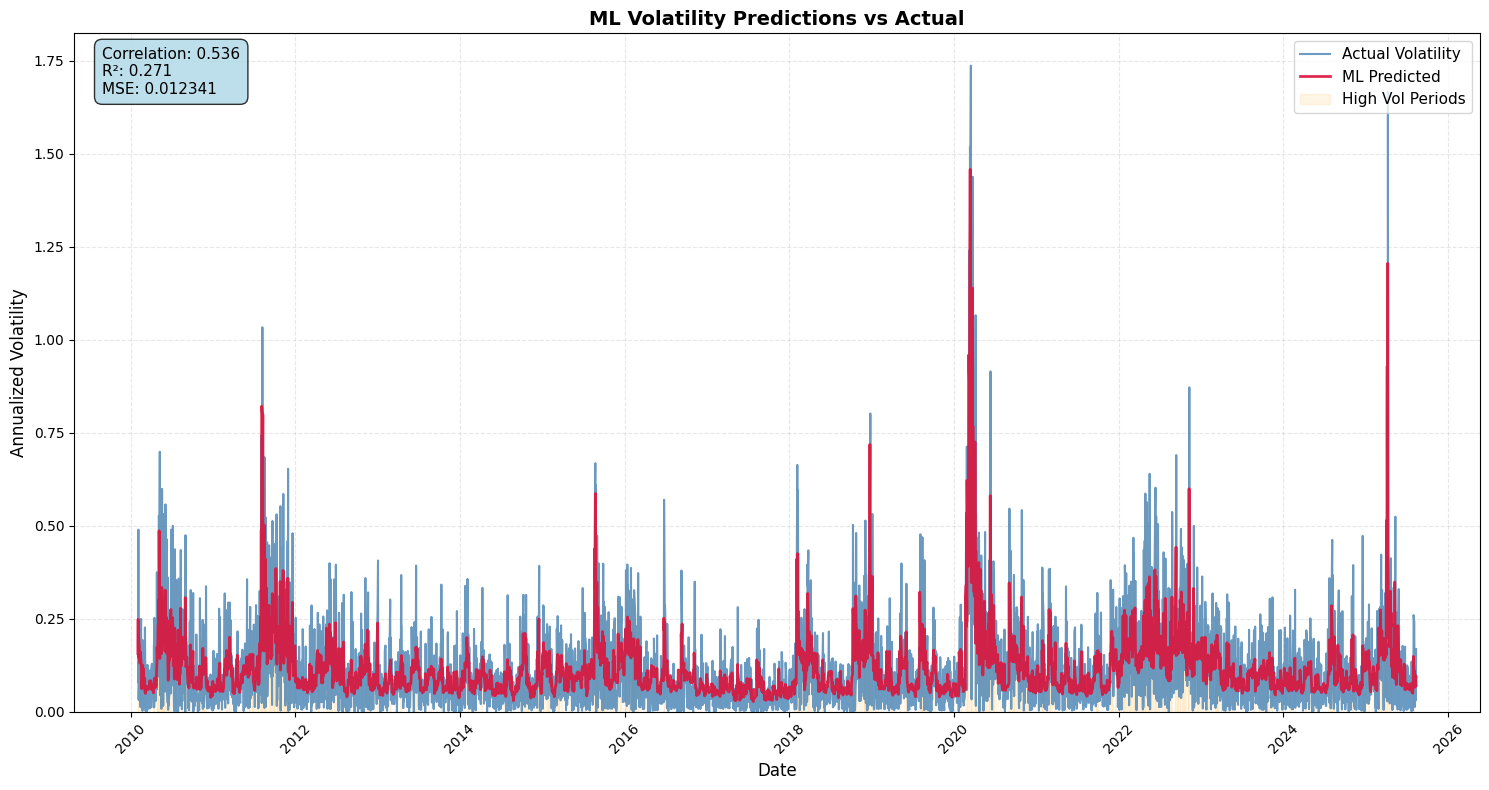

In [6]:
ml_model, ml_predictions = train_volatility_ml(df, target_col="rv_1d", verbose=True)

# Visualize ML predictions vs actual with improved styling
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# ML predictions vs realized volatility
if ml_predictions is not None:
    valid_data = ml_predictions.dropna()
    actual_vol = df["rv_1d"].loc[valid_data.index] * np.sqrt(252)  # Annualized
    predicted_vol = valid_data * np.sqrt(252)  # Annualized
    
    # Use different colors and styles for better distinction
    ax.plot(valid_data.index, actual_vol, label='Actual Volatility', 
            color='steelblue', alpha=0.8, linewidth=1.5)
    ax.plot(valid_data.index, predicted_vol, label='ML Predicted', 
            color='crimson', alpha=0.9, linewidth=2)
    
    # Add a subtle background fill for periods of high volatility
    high_vol_threshold = actual_vol.quantile(0.8)
    ax.fill_between(valid_data.index, 0, actual_vol, 
                    where=(actual_vol > high_vol_threshold), 
                    alpha=0.1, color='orange', label='High Vol Periods')
    
    ax.set_ylabel("Annualized Volatility", fontsize=12)
    ax.set_title("ML Volatility Predictions vs Actual", fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim(bottom=0)
    
    # Format x-axis
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Date", fontsize=12)
    
    # Calculate and display metrics in a text box
    corr = np.corrcoef(actual_vol, predicted_vol)[0,1]
    mse = mean_squared_error(actual_vol, predicted_vol)
    r2 = r2_score(actual_vol, predicted_vol)
    
    # Enhanced text box with multiple metrics
    metrics_text = f'Correlation: {corr:.3f}\nR²: {r2:.3f}\nMSE: {mse:.6f}'
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8),
            fontsize=11, verticalalignment='top')

plt.tight_layout()
plt.show()

In [8]:
# Display ML Model Performance Statistics as DataFrame
if ml_predictions is not None and ml_model is not None:
    valid_data = ml_predictions.dropna()
    actual_vol = df["rv_1d"].loc[valid_data.index] * np.sqrt(252)
    predicted_vol = valid_data * np.sqrt(252)
    
    # Calculate comprehensive performance metrics
    corr = np.corrcoef(actual_vol, predicted_vol)[0,1]
    mse = mean_squared_error(actual_vol, predicted_vol)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual_vol - predicted_vol))
    r2 = r2_score(actual_vol, predicted_vol)
    
    # Additional metrics
    mean_actual = actual_vol.mean()
    mean_predicted = predicted_vol.mean()
    std_actual = actual_vol.std()
    std_predicted = predicted_vol.std()
    
    # Create performance DataFrame
    performance_metrics = pd.DataFrame({
        'Metric': [
            'Correlation',
            'R²',
            'MSE',
            'RMSE', 
            'MAE',
            'Mean Actual Vol',
            'Mean Predicted Vol',
            'Std Actual Vol',
            'Std Predicted Vol',
            'Prediction Bias',
            'Sample Size'
        ],
        'Value': [
            f"{corr:.4f}",
            f"{r2:.4f}",
            f"{mse:.6f}",
            f"{rmse:.4f}",
            f"{mae:.4f}",
            f"{mean_actual:.4f}",
            f"{mean_predicted:.4f}",
            f"{std_actual:.4f}",
            f"{std_predicted:.4f}",
            f"{(mean_predicted - mean_actual):.4f}",
            f"{len(actual_vol):,}"
        ],
        'Description': [
            'Linear correlation between actual and predicted',
            'Coefficient of determination (explained variance)',
            'Mean squared error',
            'Root mean squared error',
            'Mean absolute error',
            'Average actual volatility (annualized)',
            'Average predicted volatility (annualized)',
            'Standard deviation of actual volatility',
            'Standard deviation of predicted volatility',
            'Systematic over/under-prediction',
            'Number of prediction observations'
        ]
    })
    
    print("ML VOLATILITY MODEL PERFORMANCE SUMMARY")
    print("=" * 60)
    display(performance_metrics)
    
    # Additional insights
    print(f"\nKey Insights:")
    print(f"• Model explains {r2*100:.1f}% of volatility variance")
    print(f"• Average prediction error: {mae:.4f} ({mae/mean_actual*100:.1f}% of mean)")
    print(f"• Prediction bias: {'Under' if mean_predicted < mean_actual else 'Over'}prediction by {abs(mean_predicted - mean_actual):.4f}")
else:
    print("ML model not available or no predictions generated")

ML VOLATILITY MODEL PERFORMANCE SUMMARY


,Metric,Value,Description
0,Correlation,0.5363,Linear correlation between actual and predicted
1,R²,0.2711,Coefficient of determination (explained variance)
2,MSE,0.012341,Mean squared error
3,RMSE,0.1111,Root mean squared error
4,MAE,0.0739,Mean absolute error
5,Mean Actual Vol,0.1149,Average actual volatility (annualized)
6,Mean Predicted Vol,0.1143,Average predicted volatility (annualized)
7,Std Actual Vol,0.1301,Standard deviation of actual volatility
8,Std Predicted Vol,0.0865,Standard deviation of predicted volatility
9,Prediction Bias,-0.0007,Systematic over/under-prediction



Key Insights:
• Model explains 27.1% of volatility variance
• Average prediction error: 0.0739 (64.3% of mean)
• Prediction bias: Underprediction by 0.0007


## 4) Compare Volatility Models

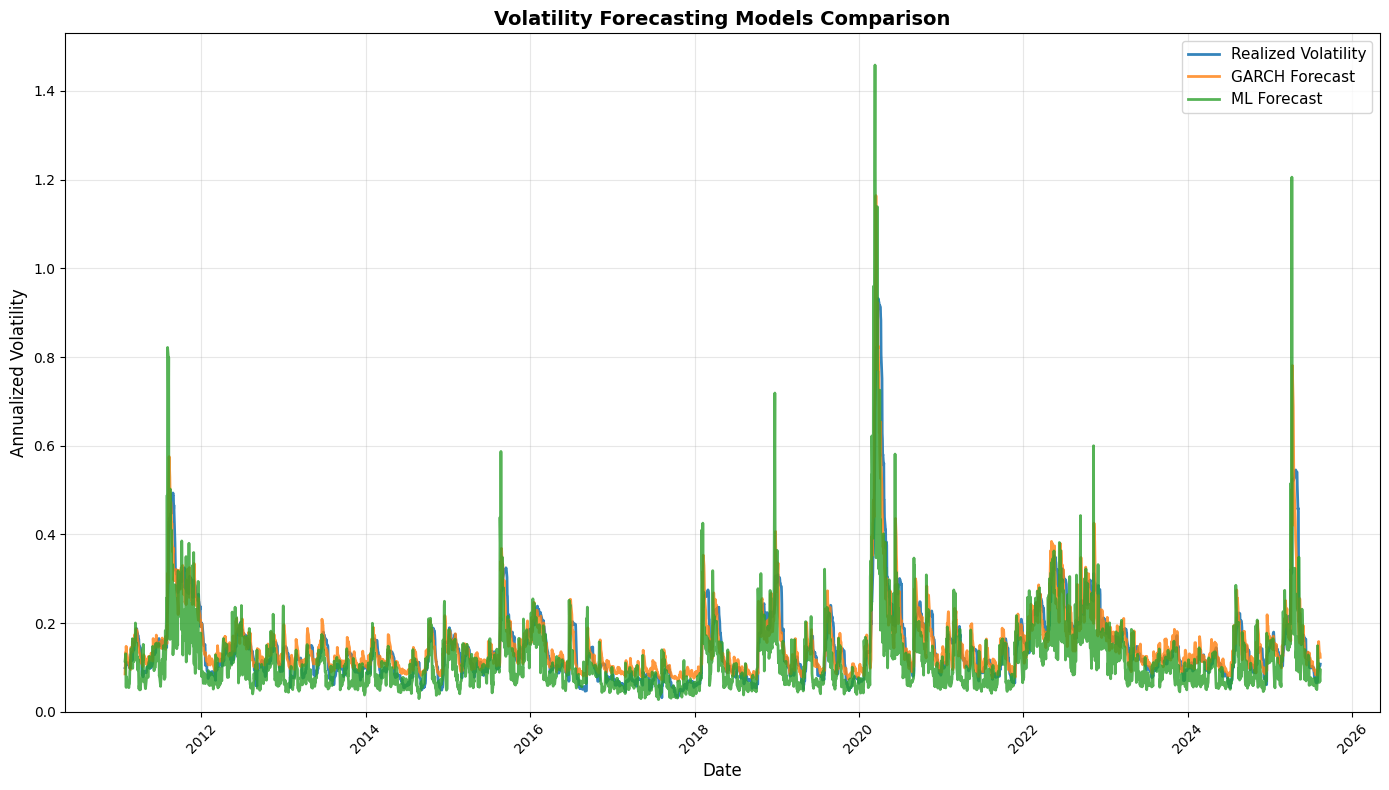

VOLATILITY FORECASTING MODELS COMPARISON


,Model,Correlation,R²,MSE,MAE,RMSE
0,GARCH,0.9092,0.8240,0.0016,0.0257,0.0395
1,ML,0.6467,0.2159,0.0070,0.0511,0.0834



Key Comparisons:
• GARCH has 1.4x higher correlation
• GARCH has 4.4x lower MSE
• GARCH explains 82.4% vs ML 21.6% of variance


In [9]:
# Combine volatility forecasts
vol_comparison = pd.DataFrame({
    "Realized": df["rv_20d"],
    "GARCH": garch_forecasts * np.sqrt(252) if garch_forecasts.notna().any() else np.nan,
    "ML": ml_predictions * np.sqrt(252) if ml_predictions is not None else np.nan
}).dropna()

# Simplified model comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Define professional color palette
colors = {'Realized': '#1f77b4', 'GARCH': '#ff7f0e', 'ML': '#2ca02c'}

# Plot time series with clear styling
ax.plot(vol_comparison.index, vol_comparison["Realized"], 
        label='Realized Volatility', color=colors['Realized'], linewidth=2, alpha=0.9)

if "GARCH" in vol_comparison.columns and vol_comparison["GARCH"].notna().any():
    ax.plot(vol_comparison.index, vol_comparison["GARCH"], 
            label='GARCH Forecast', color=colors['GARCH'], linewidth=2, alpha=0.8)

if "ML" in vol_comparison.columns and vol_comparison["ML"].notna().any():
    ax.plot(vol_comparison.index, vol_comparison["ML"], 
            label='ML Forecast', color=colors['ML'], linewidth=2, alpha=0.8)

# Clean styling
ax.set_ylabel("Annualized Volatility", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.set_title("Volatility Forecasting Models Comparison", fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

# Format x-axis
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Model Performance Comparison DataFrame
if len(vol_comparison) > 0:
    comparison_metrics = []
    
    if "GARCH" in vol_comparison.columns and vol_comparison["GARCH"].notna().any():
        garch_mse = mean_squared_error(vol_comparison["Realized"], vol_comparison["GARCH"])
        garch_corr = np.corrcoef(vol_comparison["Realized"], vol_comparison["GARCH"])[0,1]
        garch_mae = np.mean(np.abs(vol_comparison["GARCH"] - vol_comparison["Realized"]))
        garch_r2 = r2_score(vol_comparison["Realized"], vol_comparison["GARCH"])
        
        comparison_metrics.append({
            'Model': 'GARCH',
            'Correlation': garch_corr,
            'R²': garch_r2,
            'MSE': garch_mse,
            'MAE': garch_mae,
            'RMSE': np.sqrt(garch_mse)
        })
    
    if "ML" in vol_comparison.columns and vol_comparison["ML"].notna().any():
        ml_mse = mean_squared_error(vol_comparison["Realized"], vol_comparison["ML"])
        ml_corr = np.corrcoef(vol_comparison["Realized"], vol_comparison["ML"])[0,1]
        ml_mae = np.mean(np.abs(vol_comparison["ML"] - vol_comparison["Realized"]))
        ml_r2 = r2_score(vol_comparison["Realized"], vol_comparison["ML"])
        
        comparison_metrics.append({
            'Model': 'ML',
            'Correlation': ml_corr,
            'R²': ml_r2,
            'MSE': ml_mse,
            'MAE': ml_mae,
            'RMSE': np.sqrt(ml_mse)
        })
    
    # Create comprehensive comparison DataFrame
    model_comparison_df = pd.DataFrame(comparison_metrics).round(4)
    
    print("VOLATILITY FORECASTING MODELS COMPARISON")
    print("=" * 50)
    display(model_comparison_df)
    
    # Summary insights
    if len(comparison_metrics) == 2:
        garch_row = model_comparison_df[model_comparison_df['Model'] == 'GARCH'].iloc[0]
        ml_row = model_comparison_df[model_comparison_df['Model'] == 'ML'].iloc[0]
        
        print(f"\nKey Comparisons:")
        print(f"• GARCH has {garch_row['Correlation']/ml_row['Correlation']:.1f}x higher correlation")
        print(f"• GARCH has {ml_row['MSE']/garch_row['MSE']:.1f}x lower MSE")
        print(f"• GARCH explains {garch_row['R²']*100:.1f}% vs ML {ml_row['R²']*100:.1f}% of variance")
else:
    print("No comparison data available")

## 5) Risk-Adjusted Strategy Implementation

In [10]:
# Implement strategies with different volatility forecasts
strategies = {}

# Baseline: Buy & Hold
df_baseline = df.copy()
df_baseline["strat_ret"] = df_baseline["ret"]
df_baseline["equity"] = (1 + df_baseline["strat_ret"]).cumprod()
strategies["Buy_Hold"] = df_baseline

# GARCH-based strategy
if garch_forecasts.notna().any():
    df_garch = backtest_vol_strategy(df, garch_forecasts, REBALANCE_FREQ)
    strategies["GARCH_Vol"] = df_garch

# ML-based strategy  
if ml_predictions is not None:
    df_ml = backtest_vol_strategy(df, ml_predictions, REBALANCE_FREQ)
    strategies["ML_Vol"] = df_ml

# Create Strategy Performance DataFrame
strategy_performance = []
for name, strat_df in strategies.items():
    metrics = compute_metrics(strat_df)
    strategy_performance.append({
        'Strategy': name,
        'CAGR': metrics.cagr,
        'Sharpe': metrics.sharpe,
        'Max_Drawdown': metrics.max_dd,
        'Total_Return': metrics.total_return,
        'Volatility': metrics.realized_vol
    })

performance_df = pd.DataFrame(strategy_performance)

print("STRATEGY PERFORMANCE COMPARISON")
print("=" * 50)
display(performance_df.round(4))

# Performance improvement analysis
if len(performance_df) > 1:
    baseline = performance_df[performance_df['Strategy'] == 'Buy_Hold'].iloc[0]
    
    print(f"\nPerformance vs Buy & Hold:")
    for _, row in performance_df.iterrows():
        if row['Strategy'] != 'Buy_Hold':
            cagr_improvement = (row['CAGR'] / baseline['CAGR'] - 1) * 100
            sharpe_improvement = (row['Sharpe'] / baseline['Sharpe'] - 1) * 100
            print(f"• {row['Strategy']}: +{cagr_improvement:.1f}% CAGR, +{sharpe_improvement:.1f}% Sharpe")

STRATEGY PERFORMANCE COMPARISON


,Strategy,CAGR,Sharpe,Max_Drawdown,Total_Return,Volatility
0,Buy_Hold,0.1411,0.7665,-0.3372,6.8365,0.1734
1,GARCH_Vol,0.2464,0.7765,-0.5879,29.2224,0.3382
2,ML_Vol,0.2633,0.8066,-0.5584,36.0557,0.3443



Performance vs Buy & Hold:
• GARCH_Vol: +74.6% CAGR, +1.3% Sharpe
• ML_Vol: +86.6% CAGR, +5.2% Sharpe


## 6) Strategy Visualization & Export

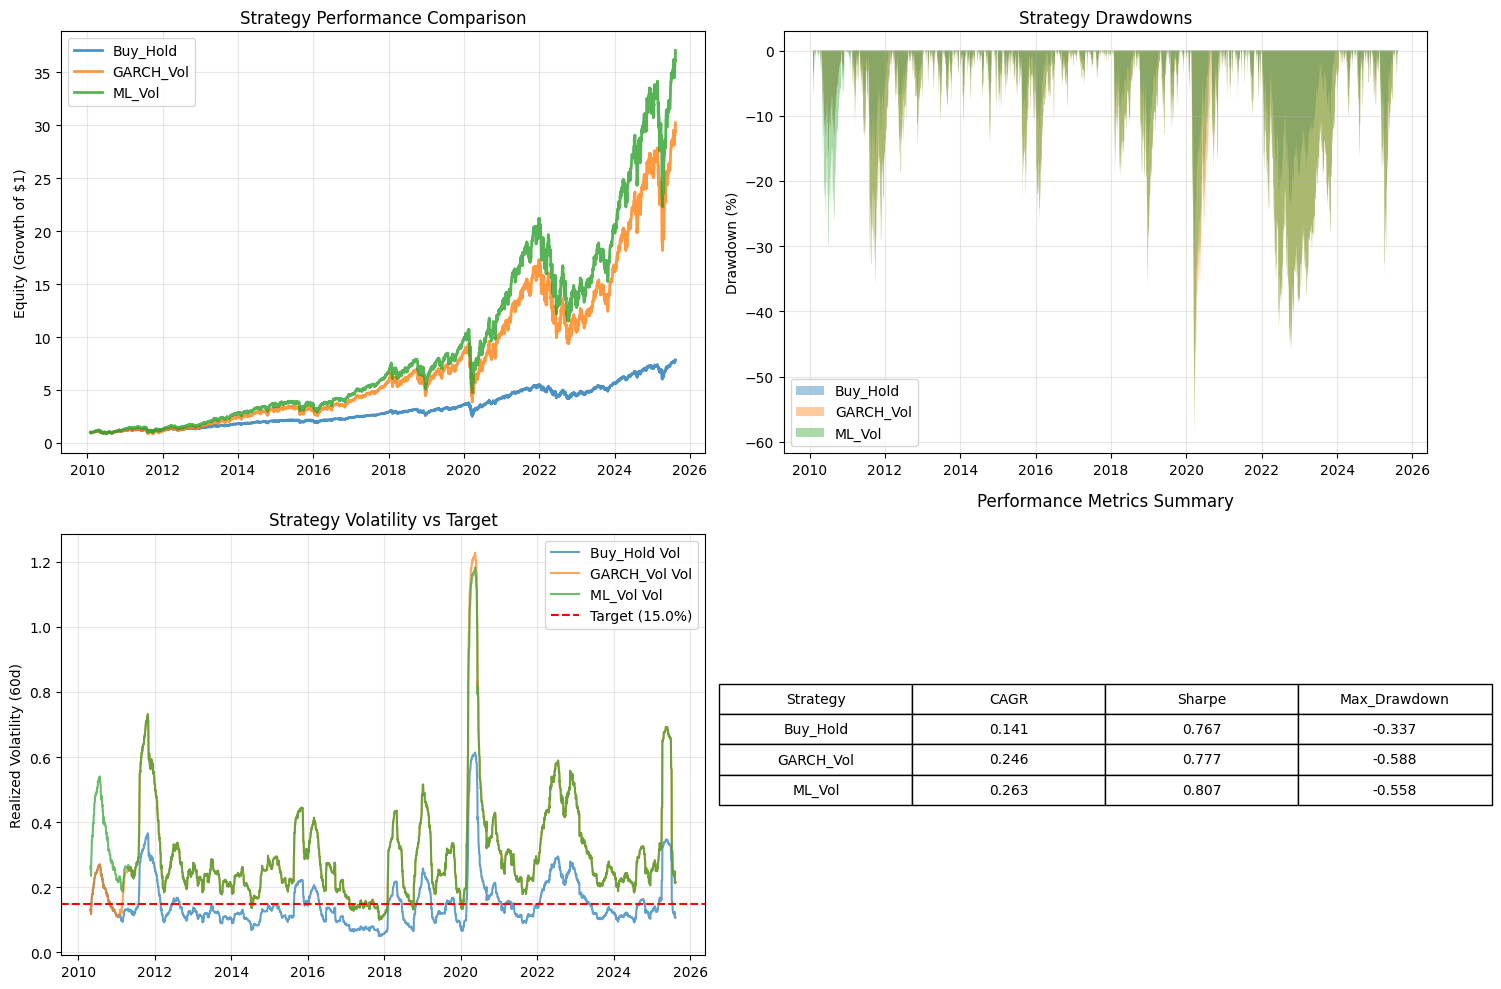


Results exported to volatility_strategies.csv
Total strategies tested: 3


In [11]:
# Comprehensive strategy comparison
fig = plt.figure(figsize=(15, 10))

# Top: Equity curves
ax1 = plt.subplot(2, 2, 1)
for name, strat_df in strategies.items():
    ax1.plot(strat_df.index, strat_df["equity"], label=name, linewidth=2, alpha=0.8)
ax1.set_ylabel("Equity (Growth of $1)")
ax1.set_title("Strategy Performance Comparison")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top right: Drawdowns
ax2 = plt.subplot(2, 2, 2)
for name, strat_df in strategies.items():
    dd = (strat_df["equity"] / strat_df["equity"].cummax() - 1) * 100
    ax2.fill_between(strat_df.index, dd, 0, alpha=0.4, label=name)
ax2.set_ylabel("Drawdown (%)")
ax2.set_title("Strategy Drawdowns")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bottom left: Rolling volatility vs target
ax3 = plt.subplot(2, 2, 3)
for name, strat_df in strategies.items():
    if "strat_ret" in strat_df.columns:
        rolling_vol = strat_df["strat_ret"].rolling(60).std() * np.sqrt(252)
        ax3.plot(strat_df.index, rolling_vol, label=f'{name} Vol', alpha=0.7)
ax3.axhline(y=VOL_TARGET, color='red', linestyle='--', label=f'Target ({VOL_TARGET:.1%})')
ax3.set_ylabel("Realized Volatility (60d)")
ax3.set_title("Strategy Volatility vs Target")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Bottom right: Performance metrics table
ax4 = plt.subplot(2, 2, 4)
if len(performance_df) > 0:
    # Create a cleaner metrics display
    display_metrics = performance_df[['Strategy', 'CAGR', 'Sharpe', 'Max_Drawdown']].copy()
    
    ax4.axis('tight')
    ax4.axis('off')
    table = ax4.table(cellText=display_metrics.round(3).values,
                      colLabels=display_metrics.columns,
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title("Performance Metrics Summary", pad=20)

plt.tight_layout()
plt.show()

# Export results
results_export = pd.DataFrame({
    name: strat_df["equity"] for name, strat_df in strategies.items()
})

# Add volatility forecasts
if garch_forecasts.notna().any():
    results_export["GARCH_Forecast"] = garch_forecasts * np.sqrt(252)
if ml_predictions is not None:
    results_export["ML_Forecast"] = ml_predictions * np.sqrt(252)
results_export["Realized_Vol"] = df["rv_20d"]

results_export.to_csv("volatility_strategies.csv", index=True)
print(f"\nResults exported to volatility_strategies.csv")
print(f"Total strategies tested: {len(strategies)}")